# Creation of synthetic data for Wisoncsin Breat Cancer data set using CTGAN Generative Advesarial Network (GAN). Tested using a logistic regression model.

## Aim

To test CT-Generative Advesarial Network (GAN) for synthesising data that can be used to train a logistic regression machine learning model.

Generative Advesarial Networks (GANs) are composed of two competing networks:

* A *descriminator* network: This produces an output (0-1) that determines whether a particular example is fake (output=0) or real (output=1).
* A *generator* network: This network produces synthetic (fake) examples

The networks are trained together. With each iteration:

* The *descriminator* network is trained on a set of labelled examples (real examples have a label of 1, those produced by the gernator network have a label of 0).
* The *generator* network is trained by passing generated examples to the *descriminator* network. The loss function is the difference between the *descriminator* output and a value of 1 (for an example which is classified as 100% probability of being real by the *descriminator network*). The *descriminator* output is passed to the *generator network* complete with *gradients*, so that the *generator network* can be trained with gradients back from the *descriminator* output (see figure below).

Improvement in the *descriminator* network provides a better feedback to the *generator network*, producing better examples. 

![](../images/generative-adversarial-network.png)

Goodfellow I, Pouget-Abadie J, Mirza M, et al. Generative Adversarial Nets. In: Ghahramani Z, Welling M, Cortes C, et al., eds. Advances in Neural Information Processing Systems 27. Curran Associates, Inc. 2014. 2672–2680.http://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf

### CTGAN

CTGAN is a Python/PyTorch package developed to make it easy to use GANs for tabular data.

GitHub page: https://github.com/sdv-dev/CTGAN

Key features of CTGAN include:

* *Preprocessing*: CTGAN uses more sophisticated Variational Gaussian Mixture Model to detect modes of continuous columns.
* *Network structure*: TGAN uses LSTM to generate synthetic data column by column. CTGAN uses Fully-connected networks which is more efficient.
* Features to prevent mode collapse*: We design a conditional generator and resample the training data to prevent model collapse on discrete columns. We use WGANGP and PacGAN to stabilize the training of GAN.
* *Data types*: CTGAN can handle continuous and discrete/categorical data (interger data needs an additional step to convert from float to integer).
* *Source data*: CTGAN works from NumPy or Pandas source data.

Lei Xu, Maria Skoularidou, Alfredo Cuesta-Infante, Kalyan Veeramachaneni. Modeling Tabular data using Conditional GAN. NeurIPS, 2019.

Xu, Lei, Maria Skoularidou, Alfredo Cuesta-Infante, and Kalyan Veeramachaneni (2019). ‘Modeling Tabular Data Using Conditional GAN’. ArXiv:1907.00503 http://arxiv.org/abs/1907.00503.


## Data

Raw data is avilable at: 

https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

## Basic methods description

* Create synthetic data by use of a Generative Adversarial Network (GAN)
* Train logistic regression model on synthetic data and test against held-back raw data

### Import modules

In [1]:
from IPython.display import clear_output

from ctgan import CTGANSynthesizer
ctgan = CTGANSynthesizer()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Turn warnings off for notebook publication
import warnings
warnings.filterwarnings("ignore")

### Import Data

Data is imported from local wisconsin.csv file (held in same directory as this notebook). Data can also be accessed here: https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

In [2]:
def load_data():
    """"
    Load Wisconsin Breast Cancer Data Set
    
    Inputs
    ------
    None
    
    Returns
    -------
    X: NumPy array of X
    y: Numpy array of y
    col_names: column names for X
    """    
    
    # Load data and drop 'id' column
    data = pd.read_csv('./wisconsin.csv')
    data.drop('id', axis=1, inplace=True)

    # Change 'diagnosis' column to 'label', and put in last column place
    data['label'] = data['diagnosis'] == 'M'
    data.drop('diagnosis', axis=1, inplace=True)

    # Split data in X and y
    X = data.drop(['label'], axis=1)
    y = data['label'] * 1.0 # convert to 0/1
    
    # Get col names and convert to NumPy arrays
    X_col_names = list(X)
    X = X.values
    y = y.values
    
    return data, X, y, X_col_names

### Data processing

Function for splitting X and y into training and test sets.

In [3]:
def split_into_train_test(X, y, test_proportion=0.25):    
    """"
    Randomly split X and y numpy arrays into training and test data sets
    
    Inputs
    ------
    X and y NumPy arrays
    
    Returns
    -------
    X_test, X_train, y_test, y_train Numpy arrays
    """
    
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, shuffle=True, test_size=test_proportion)
        
    return X_train, X_test, y_train, y_test  

Function to standardise data (based on mean and dtandard deviation of training data).

In [4]:
def standardise_data(X_train, X_test):
    """"
    Standardise training and tets data sets according to mean and standard
    deviation of test set
    
    Inputs
    ------
    X_train, X_test NumPy arrays
    
    Returns
    -------
    X_train_std, X_test_std
    """
    
    mu = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    
    X_train_std = (X_train - mu) / std
    X_test_std = (X_test - mu) /std
    
    return X_train_std, X_test_std
    

### Calculate accuracy measures

Function to calculate a range of accuracy scores.

In [5]:
def calculate_diagnostic_performance(actual, predicted):
    """     
    Inputs
    ------
    actual, predted numpy arrays (1 = +ve, 0 = -ve)
    
    Returns
    -------
    A dictionary of results:
    
    1)  accuracy: proportion of test results that are correct    
    2)  sensitivity: proportion of true +ve identified
    3)  specificity: proportion of true -ve identified
    4)  positive likelihood: increased probability of true +ve if test +ve
    5)  negative likelihood: reduced probability of true +ve if test -ve
    6)  diagnostic odds ratio: positive likelihood / negative likelihood
    7)  true positive rate: same as sensitivity
    8)  true negative rate: same as specificity
    9)  false positive rate: proportion of false +ves in true -ve patients
    10) false negative rate:  proportion of false -ves in true +ve patients
    11) positive predictive value: chance of true +ve if test +ve
    12) negative predictive value: chance of true -ve if test -ve
    13) actual positive rate: proportion of actual values that are +ve
    14) predicted positive rate: proportion of predicted vales that are +ve
    15) recall: same as sensitivity
    16) precision: the proportion of predicted +ve that are true +ve
    17) f1: 2 * ((precision * recall) / (precision + recall))

    *false positive rate is the percentage of healthy individuals who 
    incorrectly receive a positive test result
    * alse neagtive rate is the percentage of diseased individuals who 
    incorrectly receive a negative test result
    
    """
    
    # Calculate results 
    actual_positives = actual == 1
    actual_negatives = actual == 0
    test_positives = predicted == 1
    test_negatives = predicted == 0
    
    test_correct = actual == predicted
    accuracy = test_correct.mean()
    
    true_positives = actual_positives & test_positives
    false_positives = test_positives & actual_negatives
    true_negatives = actual_negatives & test_negatives
    false_negatives = test_negatives & actual_positives
    
    sensitivity = true_positives.sum() / actual_positives.sum()
    specificity = true_negatives.sum() / actual_negatives.sum()

    true_positive_rate = sensitivity
    true_negative_rate = specificity
    false_positive_rate = 1 - specificity
    false_negative_rate = 1 - sensitivity
    
    positive_likelihood = true_positive_rate / false_positive_rate
    negative_likelihood = false_positive_rate / true_negative_rate
    diagnostic_odds_ratio = positive_likelihood / negative_likelihood
    
    positive_predictive_value = true_positives.sum() / test_positives.sum()
    negative_predicitive_value = true_negatives.sum() / test_negatives.sum()
    
    actual_positive_rate = actual.mean()
    predicted_positive_rate = predicted.mean()
    
    recall = sensitivity
    precision = true_positives.sum() / actual_positives.sum()
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    # Add results to dictionary
    results = dict()
    results['accuracy'] = accuracy
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['diagnostic_odds_ratio'] = diagnostic_odds_ratio
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predicitive_value'] = negative_predicitive_value
    results['actual_positive_rate'] = actual_positive_rate
    results['predicted_positive_rate'] = predicted_positive_rate
    results['recall'] = recall
    results['precision'] = precision
    results['f1'] = f1
   
    return results

### Logistic Regression Model

Function to fit and test a logistic regression model (when synthetic data is used the model is fitted on synthetic data but tested on real data).

In [6]:
def fit_and_test_logistic_regression_model(X_train, X_test, y_train, y_test):    
    """"
    Fit and test logistic regression model. 
    Return a dictionary of accuracy measures.
    Calls on `calculate_diagnostic_performance` to calculate results
    
    Inputs
    ------
    X_train, X_test NumPy arrays
    
    Returns
    -------
    A dictionary of accuracy results.
    """
    
    # Fit logistic regression model 
    lr = LogisticRegression(C=0.1)
    lr.fit(X_train,y_train)

    # Predict tets set labels
    y_pred = lr.predict(X_test_std)
    
    # Get accuracy results
    accuracy_results = calculate_diagnostic_performance(y_test, y_pred)
    
    return accuracy_results

## Synthetic Data Method - CTGAN

#### Putting it all together: Training network and getting synthetic data

In [7]:
def make_synthetic_data_gan(X_original, y_original, number_of_samples=1000, 
                            epochs=1000):
    
    """
    Synthetic data generation, using a GAN
    
    Inputs
    ------
    original_data: X, y numpy arrays
    batch_size: batch size to use when training networks
    latent_dim: input dimension for generator network
    number_of_samples: number of synthetic samples to generate
    n_components: number of principal components to use for data synthesis
    
    Returns
    -------
    X_synthetic: NumPy array
    y_synthetic: NumPy array

    """
 
    # Split the training data into positive and negative
    mask = y_original == 1
    X_pos = X_original[mask]
    mask = y_original == 0
    X_neg = X_original[mask]

    # Set up list for positive and negative synthetic data sets
    synthetic_X_sets = []
    
    # Generate positive class data
    ctgan.fit(X_pos, epochs=epochs)
    x_fake_pos = ctgan.sample(number_of_samples)
    synthetic_X_sets.append(x_fake_pos)
    
    # Generate negative class data
    ctgan.fit(X_neg, epochs=epochs)
    x_fake_neg = ctgan.sample(number_of_samples)
    synthetic_X_sets.append(x_fake_neg)
        
    # Combine positive and negative and shuffle rows
    X_synthetic = np.concatenate(
            (synthetic_X_sets[0], synthetic_X_sets[1]), axis=0)

    y_synthetic_pos = np.ones((number_of_samples, 1))
    y_synthetic_neg = np.zeros((number_of_samples, 1))
    y_synthetic = np.concatenate((y_synthetic_pos, y_synthetic_neg), axis=0)

    # Randomise order of X, y
    synthetic = np.concatenate((X_synthetic, y_synthetic), axis=1)
    shuffle_index = np.random.permutation(np.arange(X_synthetic.shape[0]))
    synthetic = synthetic[shuffle_index]
    X_synthetic = synthetic[:,0:-1]
    y_synthetic = synthetic[:,-1]
                                                                   
    return X_synthetic, y_synthetic

### Main code

In [8]:
# Load data
original_data, X, y, X_col_names = load_data()

# Set up results DataFrame
results = pd.DataFrame()

Fitting classification model to raw data

In [9]:
# Set number of replicate runs
number_of_runs = 5

# Set up lists for results
accuracy_measure_names = []
accuracy_measure_data = []

for run in range(number_of_runs):
    
    # Print progress
    print (run + 1, end=' ')
    
    # Split training and test set
    X_train, X_test, y_train, y_test = split_into_train_test(X, y)

    # Standardise data    
    X_train_std, X_test_std = standardise_data(X_train, X_test)

    # Get accuracy of fitted model
    accuracy = fit_and_test_logistic_regression_model(
        X_train_std, X_test_std, y_train, y_test)
    
    # Get accuracy measure names if not previously done
    if len(accuracy_measure_names) == 0:
        for key, value in accuracy.items():
            accuracy_measure_names.append(key)
    
    # Get accuracy values
    run_accuracy_results = []
    for key, value in accuracy.items():
            run_accuracy_results.append(value)
            
    # Add results to results list
    accuracy_measure_data.append(run_accuracy_results)
    
    # Output accuracy
    percent_accuracy = accuracy['accuracy'] * 100
    print(f'Accuracy: {percent_accuracy:3.1f}')

# Strore mean and sem in results DataFrame 
accuracy_array = np.array(accuracy_measure_data)
results['raw_mean'] = accuracy_array.mean(axis=0)
results['raw_sem'] = accuracy_array.std(axis=0)/np.sqrt(number_of_runs)
results.index = accuracy_measure_names

1 Accuracy: 98.6
2 Accuracy: 97.2
3 Accuracy: 96.5
4 Accuracy: 98.6
5 Accuracy: 98.6


Fitting classification model to synthetic data

In [10]:
# Set up lists for results
accuracy_measure_names = []
accuracy_measure_data = []
synthetic_data = []

# Set number of replicate runs
number_of_runs = 5

for run in range(number_of_runs):
    
    # Print progress
    print (run + 1, end=' ')

    # Make synthetic data
    X_synthetic, y_synthetic = make_synthetic_data_gan(X, y)
    clear_output(wait=True)

    # Split training and test set
    X_train, X_test, y_train, y_test = split_into_train_test(X, y)

    # Standardise data (using synthetic data)
    X_train_std, X_test_std = standardise_data(X_synthetic, X_test)

    # Get accuracy of fitted model
    accuracy = fit_and_test_logistic_regression_model(
        X_train_std, X_test_std, y_synthetic, y_test)

    # Get accuracy measure names if not previously done
    if len(accuracy_measure_names) == 0:
        for key, value in accuracy.items():
            accuracy_measure_names.append(key)

    # Get accuracy values
    run_accuracy_results = []
    for key, value in accuracy.items():
            run_accuracy_results.append(value)
            
    # Add results to results list
    accuracy_measure_data.append(run_accuracy_results)
    
    # Output accuracy
    percent_accuracy = accuracy['accuracy'] * 100
    print(f'Accuracy: {percent_accuracy:3.1f}')
    
    # Save synthetic data set
    # -----------------------
    
    # Create a data frame with id
    synth_df = pd.DataFrame()

    # Transfer X values to DataFrame
    synth_df=pd.concat([synth_df, 
                        pd.DataFrame(X_synthetic, columns=X_col_names)],
                        axis=1)

    # Add a label
    y_list = list(y_synthetic)
    synth_df['label'] = y_list

    # Shuffle data
    synth_df = synth_df.sample(frac=1.0)
    
    # Add to synthetic data results list
    synthetic_data.append(synth_df)
    
# Store mean and sem in results DataFrame 
accuracy_array = np.array(accuracy_measure_data)
results['gan_mean'] = accuracy_array.mean(axis=0)
results['gan_sem'] = accuracy_array.std(axis=0)/np.sqrt(number_of_runs)

Accuracy: 93.7


### Show results

##### results

## Compare raw and synthetic data means and standard deviations

In [12]:
descriptive_stats_all_runs = []

for run in range(number_of_runs):
    
    synth_df = synthetic_data[run]
  
    descriptive_stats = pd.DataFrame()

    descriptive_stats['Original pos_label mean'] = \
        original_data[original_data['label'] == 1].mean()

    descriptive_stats['Synthetic pos_label mean'] = \
        synth_df[synth_df['label'] == 1].mean()

    descriptive_stats['Original neg_label mean'] = \
        original_data[original_data['label'] == 0].mean()

    descriptive_stats['Synthetic neg_label mean'] = \
        synth_df[synth_df['label'] == 0].mean()

    descriptive_stats['Original pos_label std'] = \
        original_data[original_data['label'] == 1].std()

    descriptive_stats['Synthetic pos_label std'] = \
        synth_df[synth_df['label'] == 1].std()

    descriptive_stats['Original neg_label std'] = \
        original_data[original_data['label'] == 0].std()

    descriptive_stats['Synthetic neg_label std'] = \
        synth_df[synth_df['label'] == 0].std()
    
    descriptive_stats_all_runs.append(descriptive_stats)

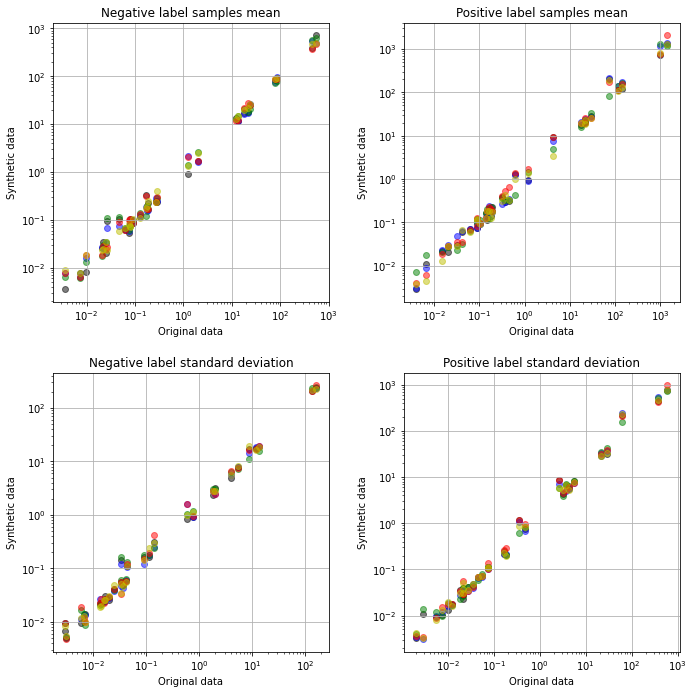

In [13]:
colours = ['k', 'b', 'g', 'r', 'y', 'c', 'm']
fig = plt.figure(figsize=(10,10))

# Negative label mean
ax1 = fig.add_subplot(221)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original neg_label mean'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic neg_label mean'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax1.scatter(x,y, color=colour, alpha=0.5)
ax1.set_xlabel('Original data')
ax1.set_ylabel('Synthetic data')
ax1.set_title('Negative label samples mean')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.grid()

# Positive label mean
ax2 = fig.add_subplot(222)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original pos_label mean'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic pos_label mean'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax2.scatter(x,y, color=colour, alpha=0.5)
ax2.set_xlabel('Original data')
ax2.set_ylabel('Synthetic data')
ax2.set_title('Positive label samples mean')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid()

# Negative label standard deviation
ax3 = fig.add_subplot(223)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original neg_label std'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic neg_label std'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax3.scatter(x,y, color=colour, alpha=0.5)
ax3.set_xlabel('Original data')
ax3.set_ylabel('Synthetic data')
ax3.set_title('Negative label standard deviation')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.grid()

# Positive label standard deviation
ax4 = fig.add_subplot(224)
for run in range(number_of_runs):
    x = descriptive_stats_all_runs[0]['Original pos_label std'].copy()
    y = descriptive_stats_all_runs[run]['Synthetic pos_label std'].copy()
    x.drop(labels ='label', inplace=True)
    y.drop(labels ='label', inplace=True)
    colour = colours[run % 7] # Cycle through 7 colours
    ax4.scatter(x,y, color=colour, alpha=0.5)
ax4.set_xlabel('Original data')
ax4.set_ylabel('Synthetic data')
ax4.set_title('Positive label standard deviation')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.grid()

plt.tight_layout(pad=2)
plt.savefig('Output/ctgan_correls.png', facecolor='w', dpi=300)
plt.show()

Calculate correlations between means and standard deviations for negative and positive classes.

In [14]:
correl_mean_neg = []
correl_std_neg = []
correl_mean_pos = []
correl_std_pos = []

for run in range(number_of_runs):
    # Get correlation of means
    x = descriptive_stats_all_runs[run]['Original neg_label mean']
    y = descriptive_stats_all_runs[run]['Synthetic neg_label mean']
    correl_mean_neg.append(np.corrcoef(x,y)[0,1])
    x = descriptive_stats_all_runs[run]['Original pos_label mean']
    y = descriptive_stats_all_runs[run]['Synthetic pos_label mean']
    correl_mean_pos.append(np.corrcoef(x,y)[0,1])
    
    # Get correlation of standard deviations
    x = descriptive_stats_all_runs[run]['Original neg_label std']
    y = descriptive_stats_all_runs[run]['Synthetic neg_label std']
    correl_std_neg.append(np.corrcoef(x,y)[0,1])
    x = descriptive_stats_all_runs[run]['Original pos_label std']
    y = descriptive_stats_all_runs[run]['Synthetic pos_label std']
    correl_std_pos.append(np.corrcoef(x,y)[0,1])

# Get correlation of means
mean_r_square_mean_neg = np.mean(np.square(correl_mean_neg))
mean_r_square_mean_pos = np.mean(np.square(correl_mean_pos))
sem_square_mean_neg = np.std(np.square(correl_mean_neg))/np.sqrt(number_of_runs)
sem_square_mean_pos = np.std(np.square(correl_mean_pos))/np.sqrt(number_of_runs)

print ('R-square of means (negative), mean (std): ', end='')
print (f'{mean_r_square_mean_neg:0.3f} ({sem_square_mean_neg:0.3f})')
print ('R-square of means (positive), mean (std): ', end='')
print (f'{mean_r_square_mean_pos:0.3f} ({sem_square_mean_pos:0.3f})')

# Get correlation of standard deviations
mean_r_square_sd_neg = np.mean(np.square(correl_std_neg))
mean_r_square_sd_pos = np.mean(np.square(correl_std_pos))
sem_square_sd_neg = np.std(np.square(correl_std_neg))/np.sqrt(number_of_runs)
sem_square_sd_pos = np.std(np.square(correl_std_pos))/np.sqrt(number_of_runs)

print ('R-square of standard deviations (negative), mean (sem): ', end='')
print (f'{mean_r_square_sd_neg:0.3f} ({sem_square_sd_neg:0.3f})')
print ('R-square of standard deviations (positive), mean (sem): ', end='')
print (f'{mean_r_square_sd_pos:0.3f} ({sem_square_sd_pos:0.3f})')

R-square of means (negative), mean (std): 0.985 (0.006)
R-square of means (positive), mean (std): 0.967 (0.010)
R-square of standard deviations (negative), mean (sem): 0.996 (0.001)
R-square of standard deviations (positive), mean (sem): 0.975 (0.003)


## Single run example

In [15]:
descriptive_stats_all_runs[0]

,Original pos_label mean,Synthetic pos_label mean,Original neg_label mean,Synthetic neg_label mean,Original pos_label std,Synthetic pos_label std,Original neg_label std,Synthetic neg_label std
radius_mean,17.462830,17.689375,12.146524,13.371294,3.203971,4.356018,1.780512,2.381736
texture_mean,21.604906,23.164856,17.914762,16.876811,3.779470,6.855629,3.995125,4.936661
perimeter_mean,115.365377,112.954678,78.075406,83.692302,21.854653,28.809613,11.807438,18.014619
area_mean,978.376415,735.076652,462.790196,387.688842,367.937978,442.164668,134.287118,205.974048
smoothness_mean,0.102898,0.094242,0.092478,0.100281,0.012608,0.017952,0.013446,0.023032
compactness_mean,0.145188,0.112360,0.080085,0.105359,0.053987,0.071283,0.033750,0.055571
concavity_mean,0.160775,0.219419,0.046058,0.106981,0.075019,0.109609,0.043442,0.110674
concave points_mean,0.087990,0.117221,0.025717,0.020034,0.034374,0.047596,0.015909,0.023186
symmetry_mean,0.192909,0.223914,0.174186,0.195173,0.027638,0.042470,0.024807,0.042221
fractal_dimension_mean,0.062680,0.069253,0.062867,0.060872,0.007573,0.010152,0.006747,0.010519


## Correlation between features

Here we calculate a correlation matric between all features for original and synthetic data.

In [16]:
neg_correlation_original = []
neg_correlation_synthetic = []
pos_correlation_original = []
pos_correlation_synthetic = []

correl_coeff_neg = []
correl_coeff_pos= []

# Original data
mask = original_data['label'] == 0
neg_o = original_data[mask].copy()
neg_o.drop('label', axis=1, inplace=True)
neg_correlation_original = neg_o.corr().values.flatten()

mask = original_data['label'] == 1
pos_o = original_data[mask].copy()
pos_o.drop('label', axis=1, inplace=True)
pos_correlation_original = pos_o.corr().values.flatten()

# Synthetic data
for i in range (number_of_runs):
    data_s = synthetic_data[i]
    
    mask = data_s['label'] == 0
    neg_s = data_s[mask].copy()
    neg_s.drop('label', axis=1, inplace=True)
    corr_neg_s = neg_s.corr().values.flatten()
    neg_correlation_synthetic.append(corr_neg_s)
    
    mask = data_s['label'] == 1
    pos_s = data_s[mask].copy()
    pos_s.drop('label', axis=1, inplace=True)
    corr_pos_s = pos_s.corr().values.flatten()
    pos_correlation_synthetic.append(corr_pos_s)

    # Get correlation coefficients
    correl_coeff_neg.append(np.corrcoef(
        neg_correlation_original, corr_neg_s)[0,1])

    correl_coeff_pos.append(np.corrcoef(
        pos_correlation_original, corr_pos_s)[0,1])

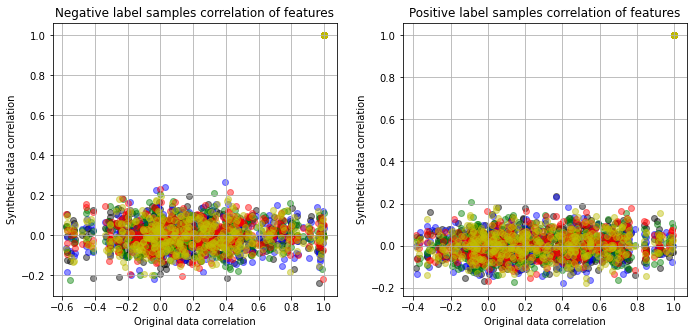

In [17]:
colours = ['k', 'b', 'g', 'r', 'y', 'c', 'm']
fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(121)
for run in range(number_of_runs):
    colour = colours[run % 7] # Cycle through 7 colours
    ax1.scatter(
        neg_correlation_original,
        neg_correlation_synthetic[run],
        color=colour,
        alpha=0.25)
ax1.grid()
ax1.set_xlabel('Original data correlation')
ax1.set_ylabel('Synthetic data correlation')
ax1.set_title('Negative label samples correlation of features')

ax2 = fig.add_subplot(122)
for run in range(number_of_runs):
    colour = colours[run % 7] # Cycle through 7 colours
    ax2.scatter(
        pos_correlation_original,
        pos_correlation_synthetic[run],
        color=colour,
        alpha=0.25)
ax2.grid()
ax2.set_xlabel('Original data correlation')
ax2.set_ylabel('Synthetic data correlation')
ax2.set_title('Positive label samples correlation of features')

plt.tight_layout(pad=2)
plt.savefig('Output/ctgan_cov.png', facecolor='w', dpi=300)
plt.show()

In [18]:
r_square_neg_mean = np.mean(np.square(correl_coeff_neg))
r_square_pos_mean = np.mean(np.square(correl_coeff_pos))
r_square_neg_sem = np.std(np.square(correl_coeff_neg))/np.sqrt(number_of_runs)
r_square_pos_sem = np.std(np.square(correl_coeff_pos))/np.sqrt(number_of_runs)

print ('Corrleation of correlations (negative), mean (sem): ', end='')
print (f'{r_square_neg_mean:0.3f} ({r_square_neg_sem:0.3f})')
print ('Corrleation of correlations (positive), mean (sem): ', end = '')
print (f'{r_square_pos_mean:0.3f} ({r_square_pos_sem:0.3f})')

Corrleation of correlations (negative), mean (sem): 0.134 (0.002)
Corrleation of correlations (positive), mean (sem): 0.146 (0.006)
